In [2]:
# Step 1 | Setup and Initialization
# Step 1.1 | Importing Necessary Libraries (Already done above)
# Step 1.2 | Loading the Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [5]:
# Step 1.2 | Loading the Dataset
df = pd.read_csv("data.csv", encoding='ISO-8859-1')
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        12/1/2010 8:26       2.55     17850.0  United Kingdom  
1        12/1/2010 8:26       3.39     17850.0  United Kingdom  
2        12/1/2010 8:26       2.75     17850.0  United Kingdom  
3        12/1/2010 8:26       3.39     17850.0  United Kingdom  
4        12/1/2010 8:26       3.39     17850.0  United Kingdom  
...                 ...        ...         ...             ...  
541904  12/9/2011 12:50       0.85     12680.0          France  
541905  12/9/2011 12:50       2.10     12680.0          France  
541906  12/9/2011 12:50       4.15     12680.0          France  
541907  12/9/2011 12:50       4.15     12680.0          France  
541908  12/9/2011 12:50       4.95     12680.0          France  

[541909 rows x 8 columns]

In [6]:
# Step 2 | Initial Data Analysis
print("Dataset Overview:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Summary Statistics:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000

In [12]:
# Step 3 | Data Cleaning & Transformation
# Handling missing values
df.dropna(inplace=True)

In [13]:
# Removing duplicates
df.drop_duplicates(inplace=True)


In [14]:
# Handling cancelled transactions
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [15]:
# Removing anomalies in StockCode
df = df[df['StockCode'].str.isnumeric()]

In [16]:
# Cleaning Description column
df['Description'] = df['Description'].str.strip()


In [17]:
# Removing zero or negative unit prices
df = df[df['UnitPrice'] > 0]


In [18]:
# Step 4 | Feature Engineering
# RFM Features
from datetime import datetime


In [21]:
# Converting InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [23]:
# Computing RFM metrics
latest_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique'

}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency',})


In [24]:

# Scaling Features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [25]:
# Step 8 | Dimensionality Reduction
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)


In [27]:
# Step 9 | K-Means Clustering
# Finding optimal k using Elbow method
wcss = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_pca)
    wcss.append(kmeans.inertia_)

plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [37]:
# Applying K-Means with optimal k
optimal_k = 4  # Assume 4 after evaluation
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_pca)


In [38]:
# Merging cluster labels into df
df = df.merge(rfm[['Cluster']], left_on='CustomerID', right_index=True, how='left')


In [39]:
# Step 12 | Recommendation System
# Identifying top products per cluster
cluster_top_products = df.groupby(['Cluster', 'StockCode'])['Quantity'].sum().reset_index()
cluster_top_products = cluster_top_products.sort_values(by=['Cluster', 'Quantity'], ascending=[True, False])


In [42]:
# Step 10 | Clustering Evaluation
silhouette_avg = silhouette_score(rfm_pca, rfm['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.6308053042767101


Column 'Monetary' not found in rfm DataFrame!


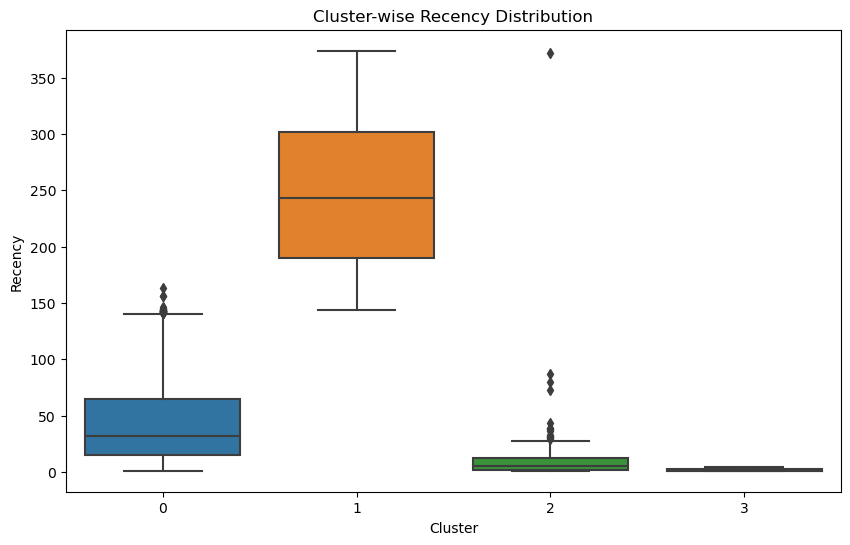

In [44]:
# Step 11 | Cluster Analysis and Profiling
def plot_boxplot(feature, title):
    if feature in rfm.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster', y=feature, data=rfm)
        plt.title(title)
        plt.show()
    else:
        print(f"Column '{feature}' not found in rfm DataFrame!")

plot_boxplot('Monetary', 'Cluster-wise Monetary Distribution')
plot_boxplot('Recency', 'Cluster-wise Recency Distribution')
plot_boxplot('Frequency', 'Cluster-wise Frequency Distribution')

In [45]:
# Step 12 | Recommendation System
# Identifying top products per cluster
cluster_top_products = df.groupby(['Cluster', 'StockCode'])['Quantity'].sum().reset_index()
cluster_top_products = cluster_top_products.sort_values(by=['Cluster', 'Quantity'], ascending=[True, False])

In [46]:
# Function to recommend top products not purchased
def recommend_products(customer_id):
    if customer_id in rfm.index:
        cluster = rfm.loc[customer_id, 'Cluster']
        purchased = set(df[df['CustomerID'] == customer_id]['StockCode'])
        top_products = cluster_top_products[cluster_top_products['Cluster'] == cluster]['StockCode'].values
        recommendations = [p for p in top_products if p not in purchased][:5]
        return recommendations
    else:
        return "Customer ID not found in RFM DataFrame."

print("Customer Segmentation and Recommendation System Completed.")


Customer Segmentation and Recommendation System Completed.


In [49]:
# Display 10 random customers with their cluster and recommendations
rfm_sample = rfm.sample(n=10, random_state=42).copy()
rfm_sample['Recommendations'] = rfm_sample.index.map(recommend_products)
display(rfm_sample)


Recency  Frequency  Cluster                      Recommendations
CustomerID                                                                  
17562.0          14          7        0  [23843, 84077, 21212, 84879, 22197]
16823.0         227          1        1  [23166, 21108, 84077, 21175, 22053]
15306.0          64          3        0  [23843, 84077, 21212, 22197, 23084]
13573.0          50          2        0  [23843, 84077, 21212, 84879, 22197]
14448.0         364          1        1  [23166, 21108, 84077, 21175, 22053]
15311.0           1         91        3  [20668, 40016, 22952, 84879, 22950]
17732.0         373          1        1  [23166, 21108, 84077, 22197, 21175]
15400.0          92          5        0  [23843, 84077, 21212, 84879, 22197]
12956.0         306          1        1  [23166, 21108, 84077, 22197, 21175]
17496.0         359          1        1  [23166, 21108, 84077, 22197, 21175]